In [30]:
# Headers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp

from astropy.io import fits
from astropy.table import Table, Column

import treecorr

from scipy.optimize import curve_fit

In [31]:
def calculate_patch_radius(patch_area_sq_degrees):
    return np.arccos(1-patch_area_sq_degrees*np.pi/(2*180*180))

sq_degrees = 250

patch_radius = calculate_patch_radius(sq_degrees)

# Input Cl's

In [32]:
def read_cl():
    l = np.loadtxt('../data/Cell_data-f1z1f1z1.dat', usecols=(0))
    l = np.append(np.array([0.0,1.0]), l[:8191])
    cl = np.loadtxt('../data/Cell_data-f1z1f1z1.dat', usecols=(1))
    cl = np.append(np.array([0.0,0.0]), cl[:8191])
    return l, cl

l , cl = read_cl()

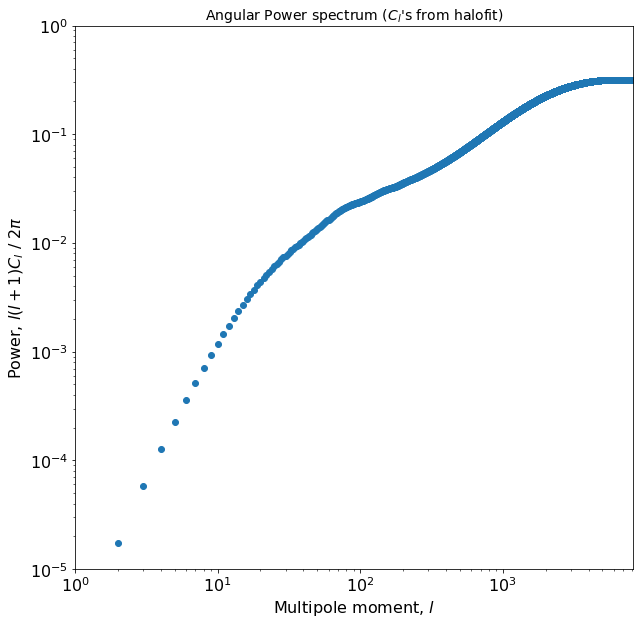

In [33]:
plt.figure(figsize=(10,10))

plt.scatter(l, l*(l+1)*cl/(2*np.pi))
plt.yscale('log')
plt.xscale('log')
plt.xlim(1,8192)
plt.ylim(1e-5,1)
plt.xlabel('Multipole moment, $l$', fontsize=16)
plt.ylabel('Power, $l(l+1)C_l$ / $2π$', fontsize=16)
plt.tick_params(labelsize=16)
plt.title('Angular Power spectrum ($C_l$\'s from halofit)', fontsize=14)
plt.savefig('./simulations_output/plot_output/Angular_power_spectrum_Cl_data.pdf')

# FLASK (for creating lognormal map)

In [34]:
# use the lognormal_map_producer.sh from terminal
# as a first step flask calculates the theoretical angular correlation function and outputs it as a .dat file

theta_flask = np.loadtxt('./simulations_output/lognormal_map/Xi_flask.dat', usecols=(0))
w_flask = np.loadtxt('./simulations_output/lognormal_map/Xi_flask.dat', usecols=(1)) # w(theta)

### Check for the value of the angular correlation function (using formula with Legendre polynomials)

In [35]:
def w_theta(theta):
    x = np.cos(theta)
    coeff = (2*l+1)/(4*np.pi)*cl
    w = np.polynomial.legendre.legval(x, coeff)
    return w     

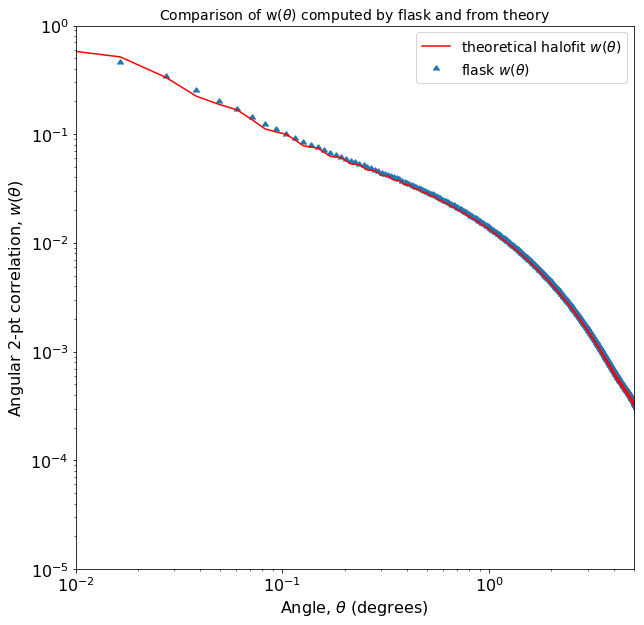

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(theta_flask, w_flask, marker=10, label='flask $w(θ)$')
plt.plot(theta_flask, w_theta(theta_flask*np.pi/180), c='r', label='theoretical halofit $w(θ)$')
plt.xlim(0.01,5)
plt.ylim(1e-5, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angle, $θ$ (degrees)', fontsize=16)
plt.ylabel('Angular 2-pt correlation, $w(θ)$', fontsize=16)
plt.tick_params(labelsize=16)
plt.title('Comparison of w($θ$) computed by flask and from theory', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.savefig('./simulations_output/plot_output/flask_and_theoretical_angular_correlation.pdf')

# Reason for the slight discrepancy between the formula (red) and flask (blue) might be due to the fact that for
# l=1, we set cl=0 (for formula computation) whereas flask uses an extrapolated cl value for l=1 which isn't 0

# Flask output: Visualize Lognormal density field in Healpy map

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<Figure size 864x864 with 0 Axes>

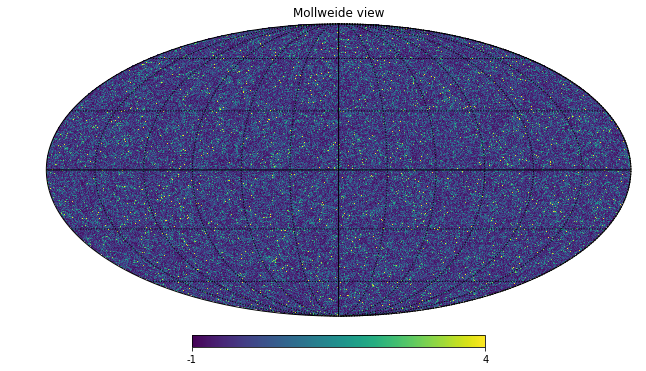

In [37]:
# flask produces the Lognormal density field (using healpy to get Gaussian field and then exponentiating)
# as a healpy fits map

density_field_lognormal = hp.fitsfunc.read_map('./simulations_output/lognormal_map/lognormal_map.fits')

nside = 2048

plt.figure(figsize=(12,12))
hp.mollview(density_field_lognormal, min=-1, max=4)
hp.graticule()
plt.savefig('./simulations_output/plot_output/density_field_lognormal_map.pdf')

# Make a single patch of pixels and save with astropy (fits) for feeding into treecorr

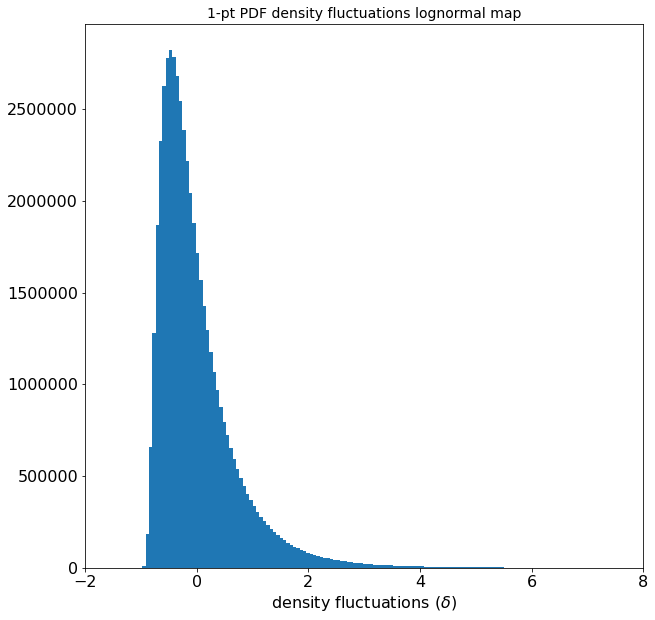

In [40]:
# Choose a random pixel i.e. center of spherical cap around which to take sq_degrees area
disc_center = hp.pix2vec(nside, 1010101)

# radius (in radians) corresponding to area of spherical cap in sky

# find the pixels 
pixels_indices_disc = hp.query_disc(nside, disc_center, patch_radius)

density_field_lognormal_disc = density_field_lognormal[pixels_indices_disc]
dec = np.pi/2 - hp.pix2ang(nside, pixels_indices_disc)[0]
RA = hp.pix2ang(nside, pixels_indices_disc)[1]

# for saving into fits file with astropy
RA_data = Column(RA, name='RA', dtype='float') # column having ra
dec_data = Column(dec, name='dec', dtype='float') # column having dec
del_data = Column(density_field_lognormal_disc, name='del', dtype='float') # column having pixels_disc_values

density_fluctuations_table = Table((RA_data, dec_data, del_data))  
# density_fluctuations_table.show_in_notebook()

density_fluctuations_table.write("./simulations_output/single_patch/density_fluctuations_lognormal_single_patch.fits" , overwrite=True)

# 1-pt PDF of density fluctuations within patch

no_of_bins = 500

plt.figure(figsize=(10,10))
#plt.hist(density_field_lognormal_disc, bins=no_of_bins)
plt.hist(density_field_lognormal, bins=no_of_bins)
plt.xlabel('density fluctuations ($δ$)', fontsize=16)
plt.tick_params(labelsize=16)
plt.xlim(-2,8)
#plt.title('1-pt PDF density fluctuations lognormal map (single patch '+str(sq_degrees)+' sq. degrees)', fontsize=14)
#plt.savefig("./simulations_output/plot_output/1_pt_PDF_single_patch/density_fluctuations_lognormal_1_pt_PDF_single_patch.pdf")
plt.title('1-pt PDF density fluctuations lognormal map', fontsize=14)
plt.savefig("./simulations_output/plot_output/1_pt_PDF_single_patch/density_fluctuations_lognormal_1_pt_PDF.pdf")

### Fit matching density function to histogram

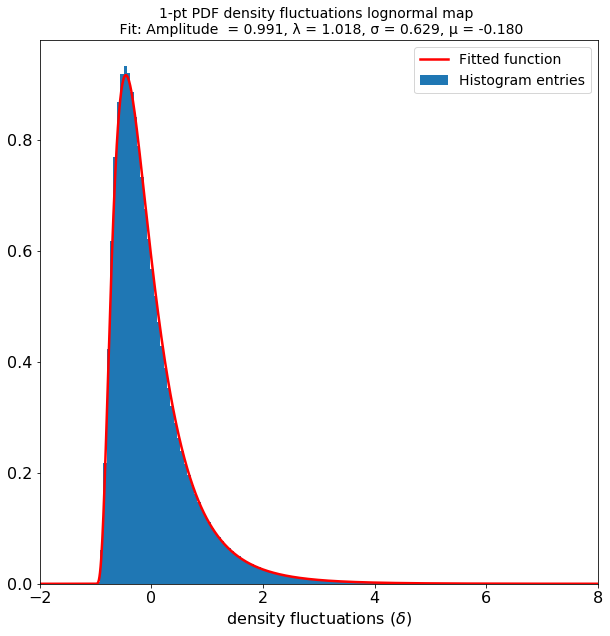

In [41]:
def lognormal_pdf(z, A, log_shift, sigma):
    return np.piecewise(z, [z > -log_shift, z <= -log_shift], 
                        [ lambda z: A*1/(np.sqrt(2*np.pi)*(z+log_shift)*sigma) *
                         np.exp(-(np.log(z/log_shift + 1) + sigma**2/2)**2/(2*sigma**2)), 0])

bin_values, bin_edges = np.histogram(density_field_lognormal_disc, bins=no_of_bins, density=True)
bin_centers = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)])

# Fit the function to the histogram data to get the optimized parameter values
popt, pcov = curve_fit(lognormal_pdf, xdata = bin_centers, ydata = bin_values, p0=[1, 1, 1])

# Generate enough x values to make the curves look smooth.
x_space = np.linspace(-2, 8, 1000)

# 1-pt PDF of density fluctuations within patch

plt.figure(figsize=(10,10))
#plt.hist(density_field_lognormal_disc, bins=no_of_bins, density=True, label=r'Histogram entries')
plt.hist(density_field_lognormal, bins=no_of_bins, density=True, label=r'Histogram entries')
#plt.bar(bin_centers, bin_values, width=bin_edges[1] - bin_edges[0], label=r'Histogram entries')
plt.plot(x_space, lognormal_pdf(x_space, *popt), color='r', linewidth=2.5, label=r'Fitted function')
plt.xlabel('density fluctuations ($δ$)', fontsize=16)
plt.tick_params(labelsize=16)
plt.xlim(-2,8)
#plt.title('1-pt PDF density fluctuations lognormal map (single patch '+str(sq_degrees)+' sq. degrees) \n Fit: Amplitude  = {0:4.3f}, λ = {1:4.3f}, σ = {2:4.3f}, μ = {3:4.3f}'.format(popt[0], popt[1], popt[2], np.log(popt[1])-popt[2]**2/2), fontsize=14)
plt.title('1-pt PDF density fluctuations lognormal map \n Fit: Amplitude  = {0:4.3f}, λ = {1:4.3f}, σ = {2:4.3f}, μ = {3:4.3f}'.format(popt[0], popt[1], popt[2], np.log(popt[1])-popt[2]**2/2), fontsize=14)
plt.legend(loc='best', fontsize=14)
#plt.savefig("./simulations_output/plot_output/1_pt_PDF_single_patch/density_fluctuations_lognormal_1_pt_PDF_single_patch.pdf")

# TreeCorr: for autocorrelation of the Lognormal density fluctuations

In [11]:
density_fluctuations = hp.read_cl('./simulations_output/single_patch/density_fluctuations_lognormal_single_patch.fits')

density_fluctuations_RA = density_fluctuations[0,:]
density_fluctuations_dec = density_fluctuations[1,:]
density_fluctuations_del = density_fluctuations[2,:]

cat = treecorr.Catalog(ra=density_fluctuations_RA, dec=density_fluctuations_dec,
                       ra_units='rad', dec_units='rad', k=density_fluctuations_del)

kk = treecorr.KKCorrelation(min_sep=1, max_sep=150, nbins=20, sep_units='arcmin')
kk.process(cat) 
theta_tc = kk.rnom
w_tc = kk.xi

dat = np.array([theta_tc, w_tc])
dat = dat.T
np.savetxt('./simulations_output/single_patch/treecorr_angular_correlation_lognormal_single_patch.txt', dat, delimiter = ' ')

# Comparison of $w(\theta)$ from treecorr and from theoretical halofit $C_l$

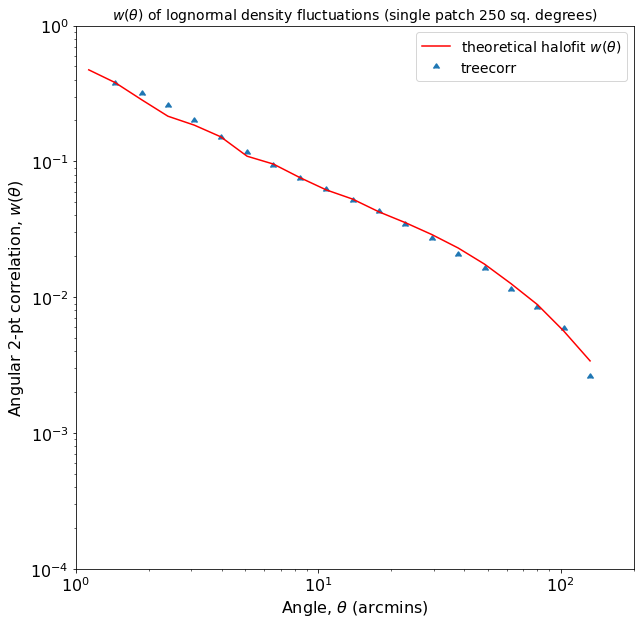

In [12]:
theta_treecorr = np.loadtxt('./simulations_output/single_patch/treecorr_angular_correlation_lognormal_single_patch.txt', usecols=(0)) # in arcmins
w_treecorr = np.loadtxt('./simulations_output/single_patch/treecorr_angular_correlation_lognormal_single_patch.txt', usecols=(1)) # w(theta)

plt.figure(figsize=(10,10))
plt.scatter(theta_treecorr,w_treecorr, marker=10, label='treecorr')
plt.plot(theta_treecorr, w_theta(theta_treecorr/60*np.pi/180), c='r', label='theoretical halofit $w(θ)$')
plt.xlim(1,200)
plt.ylim(1e-4, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angle, $θ$ (arcmins)', fontsize=16)
plt.ylabel('Angular 2-pt correlation, $w(θ)$', fontsize=16)
plt.tick_params(labelsize=16)
plt.title('$w(\\theta)$ of lognormal density fluctuations (single patch '+str(sq_degrees)+' sq. degrees)', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.savefig('./simulations_output/plot_output/treecorr_and_theoretical_angular_correlation_lognormal_single_patch.pdf')